In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

sys.path.append(os.path.expanduser("~/clef/plantclef-2025/"))

In [3]:
from plantclef.spark import get_spark

spark = get_spark()
display(spark)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/05 02:16:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/03/05 02:16:04 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


In [44]:
from pathlib import Path

home = Path.home()
knn_path = home / "scratch/plantclef/data/knn"
dataset = "test_2024"
knn_df = spark.read.parquet(str(knn_path / dataset / "k=50"))

In [5]:
knn_df.printSchema()
knn_df.show(5)

root
 |-- image_name: string (nullable = true)
 |-- tile: integer (nullable = true)
 |-- cls_embedding: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- distances: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- nn_ids: array (nullable = true)
 |    |-- element: integer (containsNull = true)
 |-- grid: string (nullable = true)



+--------------------+----+--------------------+--------------------+--------------------+----+
|          image_name|tile|       cls_embedding|           distances|              nn_ids|grid|
+--------------------+----+--------------------+--------------------+--------------------+----+
|CBN-Pla-A1-201507...|  21|[0.21448913, 1.83...|[0.9790672, 1.075...|[1030958, 1232584...| 6x6|
|CBN-PdlC-D6-20190...|  24|[-0.19922814, 0.8...|[0.9749708, 1.007...|[1232584, 1030958...| 6x6|
|CBN-PdlC-C2-20140...|   8|[1.8081415, 1.974...|[1.0173109, 1.030...|[50293, 453007, 3...| 6x6|
|CBN-Pla-E3-202006...|  12|[-0.53749895, 0.4...|[1.1672064, 1.258...|[345384, 1397442,...| 6x6|
|CBN-Pla-A6-201407...|  23|[-0.61038494, 1.9...|[1.0214908, 1.056...|[490372, 445691, ...| 6x6|
+--------------------+----+--------------------+--------------------+--------------------+----+
only showing top 5 rows



In [6]:
id_map_path = home / "scratch/plantclef/data/faiss/train/train_id_map"
id_df = spark.read.parquet(str(id_map_path))
id_df.printSchema()
id_df.show(5)

root
 |-- id: integer (nullable = true)
 |-- image_name: string (nullable = true)
 |-- species_id: integer (nullable = true)

+---+--------------------+----------+
| id|          image_name|species_id|
+---+--------------------+----------+
|  0|3a2c58a78ee93b471...|   1363472|
|  1|0a0bf86d70307e8db...|   1361957|
|  2|7990901729be71186...|   1363472|
|  3|80257a4818f5955f9...|   1392612|
|  4|e13e476d0dc36ed7b...|   1360562|
+---+--------------------+----------+
only showing top 5 rows



In [8]:
import pandas as pd
from pyspark.sql.functions import col, slice as spark_slice, median, min as spark_min, explode, arrays_zip, percentile_approx, collect_list, expr
from pyspark.sql.window import Window

In [45]:
top_k = 5

grid_sizes = [3, 4, 6]
grid_strs = [f"{s}x{s}" for s in grid_sizes]
filtered_df = (
    knn_df
    .filter(knn_df.grid.isin(grid_strs))
    .withColumn("nn_ids", spark_slice(col("nn_ids"), 1, top_k))
    .withColumn("distances", spark_slice(col("distances"), 1, top_k))
)
filtered_df.show(5)
filtered_df.count()

+--------------------+----+--------------------+--------------------+--------------------+----+
|          image_name|tile|       cls_embedding|           distances|              nn_ids|grid|
+--------------------+----+--------------------+--------------------+--------------------+----+
|CBN-Pla-F5-201308...|   2|[0.88047934, 1.95...|[0.9706346, 0.994...|[1030958, 50293, ...| 6x6|
|CBN-PdlC-A4-20200...|  15|[0.36177894, 1.17...|[1.0741732, 1.169...|[1112860, 1242945...| 6x6|
|CBN-Pla-F5-201409...|  25|[0.14248312, 0.97...|[0.87368023, 0.93...|[1198784, 364477,...| 6x6|
|CBN-Pla-D4-202008...|  16|[0.27229214, 1.25...|[0.7963917, 0.854...|[1189846, 701710,...| 6x6|
|CBN-Pla-F3-201308...|  11|[-0.16221362, 2.1...|[1.1174055, 1.119...|[20659, 1198784, ...| 6x6|
+--------------------+----+--------------------+--------------------+--------------------+----+
only showing top 5 rows



103395

In [46]:
exploded_df = (
    filtered_df
    .withColumn("nn_info", arrays_zip("nn_ids", "distances"))
    .withColumn("nn_info", explode("nn_info"))
    .withColumn("nn_id", col("nn_info").getItem("nn_ids"))  # ID
    .withColumn("distance", col("nn_info").getItem("distances"))  # Distance
    .select("image_name", "tile", "grid", "nn_id", "distance")
)
exploded_df.show(5)
exploded_df.count()

+--------------------+----+----+-------+----------+
|          image_name|tile|grid|  nn_id|  distance|
+--------------------+----+----+-------+----------+
|CBN-Pla-F5-201308...|   2| 6x6|1030958| 0.9706346|
|CBN-Pla-F5-201308...|   2| 6x6|  50293| 0.9942105|
|CBN-Pla-F5-201308...|   2| 6x6|1350341|0.99594915|
|CBN-Pla-F5-201308...|   2| 6x6| 260828| 1.0492289|
|CBN-Pla-F5-201308...|   2| 6x6|  62626| 1.0509398|
+--------------------+----+----+-------+----------+
only showing top 5 rows



516975

In [47]:
joined_df = (
    exploded_df
    .join(id_df, exploded_df.nn_id == id_df.id, "inner")
    .drop(
        id_df["id"],
        id_df["image_name"],
    )
)
joined_df.show(5)
joined_df.count()

+--------------------+----+----+-----+---------+----------+
|          image_name|tile|grid|nn_id| distance|species_id|
+--------------------+----+----+-----+---------+----------+
|OPTMix-057-P1-191...|  22| 6x6| 1483|1.1199174|   1356404|
|OPTMix-057-P1-191...|  28| 6x6| 1483|1.1610701|   1356404|
|OPTMix-057-P1-191...|   5| 3x3| 1483|1.1300431|   1356404|
|RNNB-6-10-2024011...|  33| 6x6| 2156|1.3340116|   1357771|
|RNNB-3-1-20230512...|   4| 6x6| 4612|1.2298062|   1363413|
+--------------------+----+----+-----+---------+----------+
only showing top 5 rows



516975

In [48]:
med_per_tile_species_df = (
    joined_df
    .groupBy("image_name", "tile", "grid", "species_id")
    .agg(median("distance").alias("med_distance"))
)
med_per_tile_species_df.show(5)
med_per_tile_species_df.count()

+--------------------+----+----+----------+------------------+
|          image_name|tile|grid|species_id|      med_distance|
+--------------------+----+----+----------+------------------+
|CBN-PdlC-A1-20130...|   0| 3x3|   1622901|1.1661185026168823|
|CBN-PdlC-A1-20130...|   1| 4x4|   1392333|1.0867536067962646|
|CBN-PdlC-A1-20130...|   2| 3x3|   1418612|1.0993012189865112|
|CBN-PdlC-A1-20130...|   3| 4x4|   1390904| 1.016113042831421|
|CBN-PdlC-A1-20130...|   5| 4x4|   1390793|0.8471294641494751|
+--------------------+----+----+----------+------------------+
only showing top 5 rows



400499

In [49]:
min_med_per_species_df = (
    med_per_tile_species_df
    .groupBy("image_name", "species_id")
    .agg(spark_min("med_distance").alias("min_med_distance"))
)
min_med_per_species_df.show(5)
min_med_per_species_df.count()

+--------------------+----------+------------------+
|          image_name|species_id|  min_med_distance|
+--------------------+----------+------------------+
|CBN-PdlC-A1-20160...|   1360400| 1.267442226409912|
|CBN-PdlC-A1-20180...|   1743999|1.1865174770355225|
|CBN-PdlC-A3-20190...|   1393659|0.9737672805786133|
|CBN-PdlC-A4-20140...|   1390846|0.8893802165985107|
|CBN-PdlC-A4-20170...|   1390793| 0.830958366394043|
+--------------------+----------+------------------+
only showing top 5 rows



98181

In [58]:
percentile = 0.05
window_spec = Window.partitionBy("image_name")
percentile_df = min_med_per_species_df.withColumn(
    "threshold", 
    percentile_approx("min_med_distance", percentile).over(window_spec)
)
# percentile_df.show(10)
percentile_df.sample(0.0005).show(10)
percentile_df.count()

+--------------------+----------+------------------+------------------+
|          image_name|species_id|  min_med_distance|         threshold|
+--------------------+----------+------------------+------------------+
|CBN-PdlC-A1-20140...|   1361067|1.1409962177276611|0.9384316205978394|
|CBN-PdlC-A2-20160...|   1361367|1.2515268325805664|0.7007163763046265|
|CBN-PdlC-A3-20150...|   1391331|1.0512290000915527|0.7845488786697388|
|CBN-PdlC-A5-20150...|   1398675|1.1379972696304321|0.9734244346618652|
|CBN-PdlC-B1-20190...|   1390846| 1.153586745262146|0.8440489768981934|
|CBN-PdlC-B1-20200...|   1645887|1.0850348472595215|1.0635039806365967|
|CBN-PdlC-B2-20140...|   1590997|1.2323768138885498|0.7283170223236084|
|CBN-PdlC-B3-20140...|   1744235|1.1786420345306396|0.9239225387573242|
|CBN-PdlC-B3-20180...|   1390874|1.1551555395126343| 1.011999487876892|
|CBN-PdlC-B5-20180...|   1388766| 1.143423318862915|0.8108183145523071|
+--------------------+----------+------------------+------------

98181

In [59]:
all_percentile_df = min_med_per_species_df.agg(
    percentile_approx("min_med_distance", percentile).alias("top_percentile")
)
all_percentile_value = all_percentile_df.collect()[0][0]
all_percentile_value

0.8548853397369385

In [60]:
all_images_df = knn_df.select("image_name").distinct()
\
species_groups_df = (
    percentile_df
    .filter(col("min_med_distance") <= col("threshold"))
    # .filter(col("min_med_distance") <= 1)
    # .filter(col("min_med_distance") <= all_percentile_value)
    .groupBy("image_name")
    .agg(collect_list("species_id").alias("species_ids"))
)

predictions_df = (
    all_images_df
    .join(species_groups_df, "image_name", "left")
    .withColumn("species_ids", expr("coalesce(species_ids, array())")) # replace null with empty array
    .withColumn(
        "plot_id", 
        expr("substring_index(image_name, '.', 1)")
    )
    .select("plot_id", "species_ids")
)
predictions_df.show(10)
predictions_df.count()

+--------------------+--------------------+
|             plot_id|         species_ids|
+--------------------+--------------------+
|CBN-PdlC-E6-20180815|[1390793, 1394311...|
|CBN-PdlC-E4-20160726|[1396733, 1737699...|
|CBN-PdlC-E1-20150831|[1390793, 1396733...|
| CBN-Pla-C6-20200814|  [1390899, 1394311]|
|   RNNB-4-1-20240117|  [1361723, 1361703]|
|CBN-PdlC-D3-20200722|[1419963, 1390793...|
|CBN-PdlC-F6-20130903|  [1390793, 1394311]|
| CBN-Pla-D1-20180906|[1394311, 1390793...|
|CBN-PdlC-D4-20150831|[1395807, 1390793...|
|OPTMix-0333-P2-11...|[1362581, 1361000...|
+--------------------+--------------------+
only showing top 10 rows



1695

In [61]:
from pyspark.sql.functions import size
predictions_df.filter(size(predictions_df.species_ids) == 0).count()

0

+-------+------------------+
|summary|     species_count|
+-------+------------------+
|  count|              1695|
|   mean|3.3740412979351033|
| stddev|0.9871840555684457|
|    min|                 1|
|    max|                 7|
+-------+------------------+



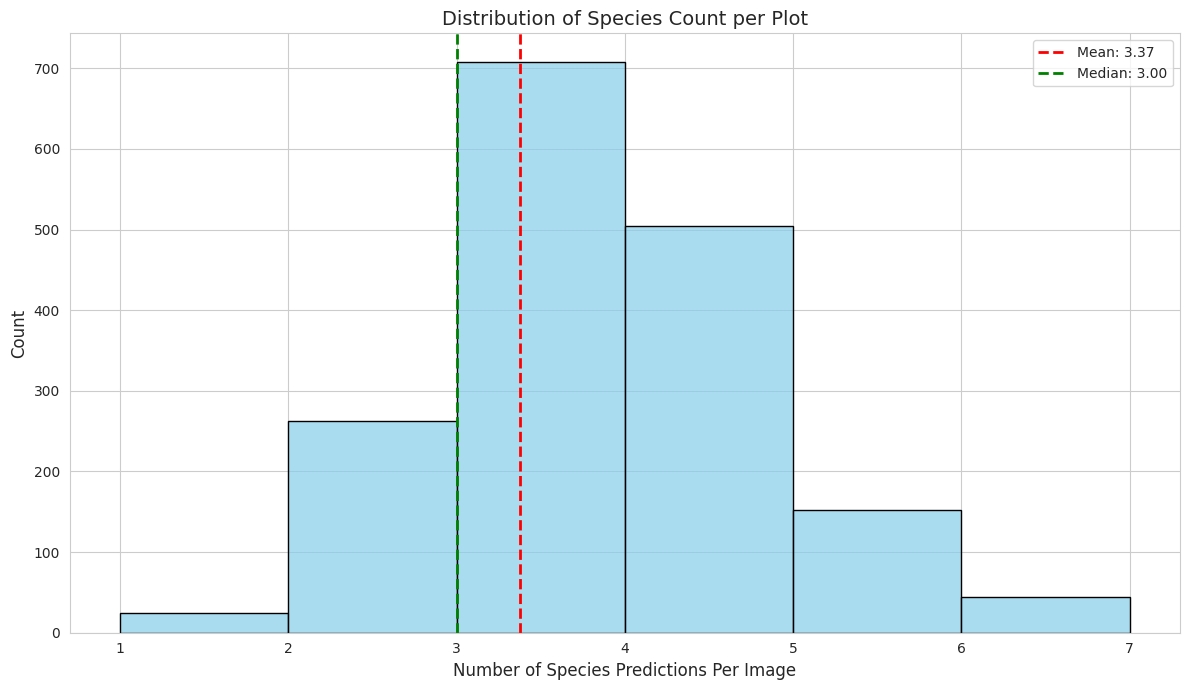

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import size

# Create species count column
predictions_with_count_df = predictions_df.withColumn(
    "species_count", 
    size("species_ids")
)
predictions_with_count_df.select("species_count").describe().show()

predictions_pd = predictions_with_count_df.select("plot_id", "species_count").toPandas()

sns.set_style("whitegrid")
plt.figure(figsize=(12, 7))

ax = sns.histplot(
    data=predictions_pd, 
    x="species_count", 
    binwidth=1, 
    color="skyblue", 
    edgecolor="black", 
    alpha=0.7
)

# Add mean and median lines
mean_count = predictions_pd["species_count"].mean()
median_count = predictions_pd["species_count"].median()
plt.axvline(mean_count, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_count:.2f}')
plt.axvline(median_count, color='green', linestyle='--', linewidth=2, label=f'Median: {median_count:.2f}')

# Add labels and title
plt.xlabel("Number of Species Predictions Per Image", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Distribution of Species Count per Plot", fontsize=14)
plt.legend()

plt.tight_layout()
plt.show()